# Hands-On 2 — Rare Events and Variance Reduction with Geant4

**47th School of Computing – Latin America 2026**  
Hands-On Session 2

**Lecturer:** Jaime Romero-Barrientos   
**Contact:** jaime.romero@cern.ch   
Researcher — Chilean Nuclear Energy Commission (CCHEN)  
Researcher — Millennium Institute for Subatomic Physics at the High-Energy Frontier (SAPHIR)

<div style="display:flex; align-items:center; gap:32px;">
  <img src="https://cernbox.cern.ch/remote.php/dav/public-files/3XD5887poIjRXe6/logo_CCHEN.jpg" width="180"/>
  <img src="https://cernbox.cern.ch/remote.php/dav/public-files/foYapCY948XIY91/Logo-Saphir.png" width="200"/>
</div>

## IMPORTANT: How to work through this notebook

1. **Run all cells in order** and answer the questions as you go.  
   The notebook is designed as a guided workflow: each step builds on the previous one.

2. You will find several **helper functions** already defined.  
   This is intentional: the goal is for you to focus on the **analysis** and on understanding what is happening in the simulations.

---
## Overview

This hands-on focuses on Monte Carlo simulation of **rare-event observables** using **Geant4**, with emphasis on:

- Event-by-event estimators
- Large statistical variance and slow convergence
- Diagnosing rare-event problems
- Variance reduction through enhanced sampling
- Quantitative performance comparison using the Figure of Merit (FOM)

You will study a fixed physical problem involving an **ultra-thin target**, where most events contribute zero to the observable.
By progressively analyzing analog simulations and then applying variance reduction, you will learn how enhanced sampling can make otherwise impractical simulations feasible—**while preserving the correct expected value**.

---
## Computing environment

This hands-on is executed using:

- **Geant4 version:** 11.3.2  
- **Physics list:** FTPF_BERT_HP  
- **Computing platform:** SWAN (CERN)  
- **Storage:** CERNBox  
- **Software stack:** LCG 108 (LHC Computing Grid)

All simulations are run inside the SWAN environment to ensure a common and reproducible setup.

---
## Physical problem: rare photon interactions in a thin target <a name="physical-problem-rare-photon-target"></a>

In this hands-on we study **high-energy photon transport through a very thin target**, a prototypical **rare-interaction problem** in Monte Carlo radiation transport.

At sufficiently high photon energy and sub-millimeter target thickness, **most primary photons traverse the target without interacting at all**.  
Only a **very small fraction** of primaries undergo a physical interaction inside the target volume.

As a result:
- The quantity of interest is dominated by **rare, discrete events**
- Most histories contribute **exactly zero**
- Statistical convergence is **slow**

This makes the problem **complementary to HO1**:
- HO1: many interactions, but very few particles reach the ROI  
- HO2: many particles reach the ROI, but very few interactions occur

Both are classic **rare-event Monte Carlo problems**.

---

## Geometry and particle transport <a name="geometry-and-particle-transport-ho2"></a>

The simulated geometry consists of:

- A **100 MeV photon source** located at `z = -50 cm`, emitting particles along the `+z` axis.
- A **very thin target** of thickness **0.1 mm**, defined as the physical volume:
  - `test.phys`

Because the target is extremely thin at this energy:

- Most photons traverse the target without interacting.
- Interactions inside the target are **rare**, so the observable is dominated by a small fraction of contributing events.

**Important (scoring rule):**  
Only interactions for which the **step starts inside `test.phys`** are counted.

---

## What is scored and why <a name="scoring-and-observable"></a>

For each **primary photon**, the simulation records the quantity:

$$
Q_{\text{event}}=\sum_{\text{collisions in target}} w_i
$$

where:
- the sum runs over **all non-transportation interactions** whose step starts inside the target
- $w_i$ is the **track weight at the post-step point** of that interaction

Interpretation:
- $Q_{\text{event}} = 0$  
  → the photon did **not** interact in the target
- $Q_{\text{event}} > 0$  
  → one or more interactions occurred (rare)

The run output reports the **mean value per primary**:

$$
\langle Q\rangle=\frac{1}{N}\sum_{k=1}^{N} Q_{\text{event}}^{(k)}
$$

which you can interpret as the **(weighted) number of target interactions per primary photon**.

---

## Statistical nature of the problem <a name="statistical-nature-ho2"></a>

Because:
- most events contribute zero,
- and only a tiny fraction contribute a non-zero value,

the estimator of $\langle Q\rangle$:
- converges **slowly**,
- has **large relative uncertainty** at moderate $N$,
- and is extremely sensitive to rare contributions.

This makes it an ideal test case for:
- understanding Monte Carlo uncertainty scaling,
- and motivating variance reduction techniques.

---

## Goal of this hands-on <a name="goal-ho2"></a>

Your goal is to estimate $\langle Q\rangle$ with:

- a **relative statistical uncertainty below 1%**,  
- **within a fixed wall-clock time budget**.

You will:
- start from small statistics (many zero events),
- observe how the uncertainty scales with $N$,
- and use this information to reason about efficiency and feasibility.

## Simulation output

Each run produces:

### Screen output
- A short message indicating where the results were written:
  - Per-event file(s):
    ```
    [GB02] Writing per-event Q to: out/<runTag>_<runID>/eventQ_t<tid>.tsv (thread <tid>)
    ```
  - Run summary file:
    ```
    [GB02] Writing run summary to: out/<runTag>_<runID>/summary.tsv
    ```
  These lines tell you exactly where to find the data for *this* run.

- A run-level summary printed at the end:
  - `N events`: number of primary histories
  - `Mean(Q)`: average **weighted number of collisions in the target** (per primary)
  - `StdErr(Mean)`: standard error of the mean
  - `Rel. error (%)`: relative uncertainty of the mean (in %)
  - `Time (s)`: wall-clock time
  - `FOM (1/s)`: figure of merit (higher is better for a fixed target uncertainty)

Here the event-level observable is:
$$
Q_{\text{event}} = \sum_{k \in \text{collisions in target}} w_k
$$

and the reported quantity is:
$$
\langle Q \rangle = \frac{1}{N}\sum_{i=1}^{N} Q_{\text{event}}^{(i)} \, .
$$

### Files written to disk (`out/<runTag>_<runID>/`)
Each run creates a dedicated output folder (unique per execution), containing:

- **Per-event data** (one file per thread):
  - `eventQ_t0.tsv`, `eventQ_t1.tsv`, ...
  - Columns:
    - `eventID`: event index
    - `eventQ`: the event-level value $Q_{\text{event}}$

- **Run summary**
  - `summary.tsv`
  - Contains:
    - metadata (runTag, runID, number of threads, glob pattern for event files)
    - one-row table with: `N`, `MeanQ`, `StdErr`, `RelErr_pct`, `Time_s`, `FOM_1perS`

> **Important:** Always use the printed lines `Writing per-event Q to:` and `Writing run summary to:` to locate the correct output folder for your run.  
> **After every run:** copy/paste the **full paths** printed by the code, including filenames:
> - `.../eventQ_t0.tsv`
> - `.../summary.tsv`
>  
> You will use these exact paths later for the stability and efficiency checks.

## Download and compilation

We will now download the simulation code from GitHub and compile it inside SWAN.

In [3]:
from pathlib import Path

cwd = Path.cwd().resolve()

# Autofix: if the notebook is launched from repo root, jump to hands_on_1/
if (cwd / "hands_on_2" / "simulation").is_dir():
    HO_DIR = (cwd / "hands_on_2").resolve()
else:
    HO_DIR = cwd

SIM_DIR    = HO_DIR / "simulation"
BUILD_DIR  = SIM_DIR / "build"
OUT_DIR    = BUILD_DIR / "out"
PCRUNS_DIR = SIM_DIR / "pcruns"

print("cwd      :", cwd)
print("HO_DIR   :", HO_DIR)
print("SIM_DIR  :", SIM_DIR)
print("BUILD_DIR:", BUILD_DIR)
print("OUT_DIR  :", OUT_DIR)
print("PCRUNS   :", PCRUNS_DIR)

if not SIM_DIR.is_dir():
    raise FileNotFoundError(
        f"simulation/ not found at: {SIM_DIR}\n"
        "Open this notebook from inside hands_on_2/ or from CSC2026_VR/ root."
    )

cwd      : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2
HO_DIR   : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2
SIM_DIR  : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation
BUILD_DIR: /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation/build
OUT_DIR  : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation/build/out
PCRUNS   : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation/pcruns


In [4]:
from pathlib import Path

# --- Hands-on root (folder containing hands_on_X.ipynb) ---
HO_DIR = Path.cwd().resolve()

# --- Simulation tree ---
SIM_DIR    = HO_DIR / "simulation"
BUILD_DIR  = SIM_DIR / "build"
OUT_DIR    = BUILD_DIR / "out"
PCRUNS_DIR = SIM_DIR / "pcruns"   # precomputed runs live inside simulation/

print("HO_DIR    :", HO_DIR)
print("SIM_DIR   :", SIM_DIR)
print("BUILD_DIR :", BUILD_DIR)
print("OUT_DIR   :", OUT_DIR)
print("PCRUNS_DIR:", PCRUNS_DIR)

if not SIM_DIR.is_dir():
    raise FileNotFoundError(
        f"simulation/ not found at: {SIM_DIR}\n"
        "Tip: open this notebook from inside hands_on_1/ (or hands_on_2/) folder."
    )

HO_DIR    : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2
SIM_DIR   : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation
BUILD_DIR : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation/build
OUT_DIR   : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation/build/out
PCRUNS_DIR: /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation/pcruns


In [5]:
#
# Executing this cell will compile the exercise
#
from time import time
import os
from pathlib import Path
import subprocess

t1 = time()

print("=== Build: Hands-On 2 (GB02) ===")
print("HO_DIR    :", HO_DIR)
print("SIM_DIR   :", SIM_DIR)
print("BUILD_DIR :", BUILD_DIR)
print("OUT_DIR   :", OUT_DIR)

# --- Build directory ---
BUILD_DIR.mkdir(parents=True, exist_ok=True)

# --- Configure & build ---
print("\nRunning CMake configure...")
subprocess.run(["cmake", "-S", str(SIM_DIR), "-B", str(BUILD_DIR)], check=True)

print("Running build...")
subprocess.run(["cmake", "--build", str(BUILD_DIR), "-j"], check=True)

# --- Compilation check ---
exe = BUILD_DIR / "exampleGB02"
if exe.is_file() and os.access(exe, os.X_OK):
    print(f"\n✅ Compilation successful: '{exe.name}' found at {exe}")
else:
    raise RuntimeError(
        f"\n❌ Compilation failed: executable 'exampleGB02' not found at:\n  {exe}\n"
        "Check the output above."
    )

t2 = time()
print("\nInstalled exercise in {:.2f} minutes".format((t2 - t1) / 60.0))

=== Build: Hands-On 2 (GB02) ===
HO_DIR    : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2
SIM_DIR   : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation
BUILD_DIR : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation/build
OUT_DIR   : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation/build/out

Running CMake configure...
-- The C compiler identification is GNU 13.1.0
-- The CXX compiler identification is GNU 13.1.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /cvmfs/sft.cern.ch/lcg/releases/gcc/13.1.0-b3d18/x86_64-el9/bin/gcc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /cvmfs/sft.cern.ch/lcg/releases/gcc/13.1.0-b3d18/x86_64

## First analog run (baseline: 10k primaries)

We start by running a **baseline analog simulation** with **10,000 primary particles**.

- The **physics, geometry, and observable are fixed** throughout the hands-on.
- The **random seed is kept fixed** on purpose.
- At this stage, we are **not** trying to obtain a precise result.

### Why start with this run?

This first run serves as a **diagnostic case**:

- To observe what happens when the observable is **extremely rare**.
- To understand why many events contribute **exactly zero** to the estimator.
- To see what a **very large relative uncertainty** looks like in practice.

In other words, this is a *“case zero”*:  
it tells us **why 10k events are not enough**, rather than giving a useful estimate.

### What to record from the output

After the run finishes, write down the following quantities from the terminal output:

- `N events`
- `Mean(Q)`
- `StdErr(Mean)`
- `Rel. error (%)`
- `Time (s)`
- `FOM (1/s)`

Also, note where the output files are written, using the lines printed by the code:

- `[GB02] Writing per-event Q to: ...`
- `[GB02] Writing run summary to: ...`

You will need these paths later when analyzing the results.

---
**Important (do not change the run functions):**  
For this hands-on we **must run with 1 thread** so that the simulation writes **a single `.tsv` output file**.  
Please **do not modify** the helper/run functions provided in the notebook.  
If you change the threading settings, Geant4 will typically produce **multiple `.tsv` files (one per thread)**, which will break the expected workflow and make the analysis confusing.

---

In [6]:
import os
import subprocess
from time import time
from pathlib import Path

def run_simulation(macro, *, build_dir=BUILD_DIR, timeout=None, print_output=True):
    """
    Runs the GB02 executable from simulation/build, forcing 1 thread.

    Parameters
    ----------
    macro : str | Path
        Macro filename (e.g., "run_10k_seedA.mac") or path to a macro.
        If a relative path is given, it is interpreted relative to SIM_DIR.
    build_dir : str | Path
        Directory where 'exampleGB02' lives (default: BUILD_DIR).
    timeout : float | None
        Optional timeout in seconds.
    print_output : bool
        If True, prints the program stdout.

    Returns
    -------
    dict with keys:
        - wall_time_s
        - returncode
        - stdout
        - eventQ_path (if detected)
        - summary_path (if detected)
    """
    build_dir = Path(build_dir).resolve()
    exe = build_dir / "exampleGB02"

    macro_path = Path(macro)
    if not macro_path.is_absolute():
        macro_path = (SIM_DIR / macro_path).resolve()

    if not exe.is_file():
        raise FileNotFoundError(f"Executable not found: {exe}. Did you compile first?")
    if not macro_path.is_file():
        raise FileNotFoundError(f"Macro not found: {macro_path}")

    # Force single-thread execution (avoid multiple TSV outputs)
    env = os.environ.copy()
    env["G4FORCENUMBEROFTHREADS"] = "1"

    cmd = [str(exe), "-m", str(macro_path)]

    t1 = time()
    proc = subprocess.run(
        cmd,
        cwd=str(build_dir),   # run from build/ so outputs land in build/out/
        env=env,
        capture_output=True,
        text=True,
        timeout=timeout,
        check=False,
    )
    t2 = time()

    stdout = proc.stdout or ""
    stderr = proc.stderr or ""

    if print_output:
        print(stdout)
        if proc.returncode != 0 and stderr.strip():
            print("\n--- STDERR ---\n")
            print(stderr)

    # Detect output paths from stdout (optional convenience)
    eventQ_path = None
    summary_path = None
    for line in stdout.splitlines():
        if "[GB02] Writing per-event Q to:" in line:
            try:
                eventQ_path = line.split("to:", 1)[1].strip().split(" (thread", 1)[0].strip()
            except Exception:
                pass
        if "[GB02] Writing run summary to:" in line:
            try:
                summary_path = line.split("to:", 1)[1].strip()
            except Exception:
                pass

    result = {
        "wall_time_s": t2 - t1,
        "returncode": proc.returncode,
        "stdout": stdout,
        "eventQ_path": eventQ_path,
        "summary_path": summary_path,
    }

    print(f"\n✅ Done. Wall time: {result['wall_time_s']:.3f} s (forced 1 thread)")
    if eventQ_path:
        print(f"📄 Per-event file: {eventQ_path}")
    if summary_path:
        print(f"📄 Summary file  : {summary_path}")

    return result

In [8]:
# Run 1: Seed A
resA = run_simulation("run_10k_seedA.mac")


**************************************************************
 Geant4 version Name: geant4-11-03-patch-02 [MT]   (25-April-2025)
  << in Multi-threaded mode >> 
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Geant4 Physics List simulation engine: FTFP_BERT

      ************************************************* 
      ********** processes are not wrapped ************ 
      ************************************************* 
Accumulable registered as "accumulable_0"
Accumulable registered as "accumulable_1"
 Attaching biasing operator TestManyForceCollision to logical volume test.logical

 hInelastic FTFP_BERT : threshold between BERT and FTFP is over the interval 
 for pio

### Record your results (analog run, 10k primaries)

Write down (copy/paste) the following values from the **screen output**:

- `N events =`
- `Mean(Q) =`
- `StdErr(Mean) =`
- `Rel. error (%) =`
- `Time (s) =`
- `FOM (1/s) =`

Also copy the output paths printed by the code (you will need them later):

- Per-event file: `.../eventQ_t0.tsv`
- Summary file: `.../summary.tsv`

---

### Understanding the simulation output structure


Each run writes its results to a directory of the form:

`out/<runTag>_<runID>/`

Inside that directory you will find:

### `summary.tsv`
Run-level statistics:
- `N`
- `MeanQ`
- `StdErr`
- `RelErr_pct`
- `Time_s`
- `FOM_1perS`

This file answers the question:
> *“What is the estimator value and its uncertainty for this run?”*

### `eventQ_t0.tsv`
Per-event data (one line per primary):
- `eventID`
- `eventQ`

This file answers the question:
> *“How is the estimator built event by event?”*

You can inspect these files directly, for example:

```bash
head summary.tsv
head eventQ_t0.tsv

## Interpreting the first analog run (rare-event behavior)

After running the first analog simulation (`N = 10,000`), you should now step back and
**interpret what you observed**.

Answer the following questions **in your own words**.

---

### 1. Event-level behavior: why so many zeros?

Look at `eventQ_t0.tsv`.

- What fraction of events have `eventQ = 0`?
- Why is this expected from:
  - the target thickness,
  - the photon interaction probability,
  - and the definition of `Q_event`?

---

### 2. Uncertainty: why is the relative error so large?

Now look at the summary output.

- Why is the **relative error close to 100%**?
- Explain the connection between:
  - a large fraction of zero-contribution events,
  - rare non-zero events,
  - and the variance of the estimator.

---

### 3. Reliability of the estimate

- Is the reported `Mean(Q)` already a reliable estimate of the true value?
- What does “reliable” mean in this context?

---

### 4. Scaling intuition (before doing anything)

Without doing any calculation:

- If you increased the number of events from 10k to 20k,
  would the situation qualitatively change?
- Why or why not?

---

### 5. First conclusion

In one or two sentences:

- What is the **core difficulty** of this problem for analog Monte Carlo?
- How is this difficulty different from the deep-shielding case in HO1?

## Second analog runs: increasing statistics (same physics, same problem)

From the previous run you observed that:
- Most events have `Q_event = 0`
- The estimator is dominated by **rare interactions**
- The relative uncertainty is very large at low statistics

We now test the most obvious strategy:

> **Does simply increasing the number of events solve the problem?**

In the next cells you will run the **same simulation**, changing **only** the number of primary events:

- 30k events
- 50k events
- 100k events

---

### Important rules (for a controlled comparison)

- Keep the **same random seed**  
  *(this reduces run-to-run noise and makes trends with \(N\) easier to interpret in a hands-on setting)*

- After each run, you must:
  1. Record the key numbers from the **screen output**
  2. Record the paths of the output files printed by the program

---

### Goal of this block

By comparing these runs, you should be able to:

- Observe how the **relative error** \(R\) scales with \(N\)
- Observe how the **wall time** scales with \(N\)
- Decide whether increasing statistics alone is a **practical strategy**
  for reaching the target uncertainty in this problem

#### Run the simulation with 30,000 initial particles

In [9]:
res_30k = run_simulation("run_30k_seedA.mac")


**************************************************************
 Geant4 version Name: geant4-11-03-patch-02 [MT]   (25-April-2025)
  << in Multi-threaded mode >> 
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Geant4 Physics List simulation engine: FTFP_BERT

      ************************************************* 
      ********** processes are not wrapped ************ 
      ************************************************* 
Accumulable registered as "accumulable_0"
Accumulable registered as "accumulable_1"
 Attaching biasing operator TestManyForceCollision to logical volume test.logical

 hInelastic FTFP_BERT : threshold between BERT and FTFP is over the interval 
 for pio

### Record your results (30k)

From the **screen output**, copy:

- `N events =`
- `Mean(Q) =`
- `StdErr(Mean) =`
- `Rel. error (%) =`
- `Time (s) =`
- `FOM (1/s) =`

From the printed lines, copy the file locations:

- Per-event file: `.../eventQ_t0.tsv`
- Summary file: `.../summary.tsv`

### Quick check (30k): first non-trivial statistics

Use the numbers you just copied from the screen output and a quick glance at `eventQ_t0.tsv`.

#### A) What do the summary numbers say?

1) **Are we anywhere near the target?**
- What is `Rel. error (%)`?
- Is it already “small”, or still clearly large?

2) **Mean vs uncertainty**
- Is `StdErr(Mean)` of the same order as `Mean(Q)`, or much smaller?
- What does that imply about reliability at this N?

3) **Cost**
- What is `Time (s)`?
- Does it already feel “cheap” or “starting to cost” (for a toy problem)?

#### B) One-minute look at the event file `eventQ_t0.tsv`

4) **Zeros**
- Do you see many eventQ = 0 in the first lines?
- Based on that, do you expect the estimator to have high variance? (yes/no + one phrase)

5) **Type of contributions**
- When eventQ is non-zero, does it look like mostly 0/1-like contributions or small continuous values?
- One sentence: why does that matter for variance?

**✅ One-line checkpoint (mandatory):**
At N = 30k, the observable looks rare-event dominated / starting to show scores, because _______________________.

#### Run the simulation with 50,000 initial particles

In [10]:
res_50k = run_simulation("run_50k_seedA.mac")


**************************************************************
 Geant4 version Name: geant4-11-03-patch-02 [MT]   (25-April-2025)
  << in Multi-threaded mode >> 
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Geant4 Physics List simulation engine: FTFP_BERT

      ************************************************* 
      ********** processes are not wrapped ************ 
      ************************************************* 
Accumulable registered as "accumulable_0"
Accumulable registered as "accumulable_1"
 Attaching biasing operator TestManyForceCollision to logical volume test.logical

 hInelastic FTFP_BERT : threshold between BERT and FTFP is over the interval 
 for pio

### Record your results (50k)

From the **screen output**, copy:

- `N events =`
- `Mean(Q) =`
- `StdErr(Mean) =`
- `Rel. error (%) =`
- `Time (s) =`
- `FOM (1/s) =`

From the printed lines, copy the file locations:

- Per-event file: `.../eventQ_t0.tsv`
- Summary file: `.../summary.tsv`

### Quick check (50k): trend spotting

Use the numbers you just copied from the **screen output**. Compare only against the **immediately previous run**.

---

#### 1) Mean(Q): did it move?

Compared to the previous run, `Mean(Q)` is:
- ☐ up
- ☐ down
- ☐ ~same

Write the two values (previous → current):
- Mean(Q): __________ → __________

---

#### 2) Relative error: did it drop meaningfully?

`Rel. error (%)` is:
- ☐ lower
- ☐ ~same (barely changed)

Write the two values (previous → current):
- Rel. error (%): __________ → __________

Approximate improvement factor (previous / current):
- $R_{\text{prev}}/R_{\text{curr}} \approx$ ________

Choose the closest:
- ☐ ~1.2×
- ☐ ~1.5×
- ☐ ~2×
- ☐ >2×

One sentence: does this feel like “fast convergence” or “slow convergence”? Why?
- _____________________________________________________________

---

#### 3) Time: does it scale with N?

Write the two values (previous → current):
- Time (s): __________ → __________

Compute the ratios:
- $N_{\text{curr}}/N_{\text{prev}} =$ ________
- $T_{\text{curr}}/T_{\text{prev}} =$ ________

Interpretation (pick one):
- ☐ roughly proportional (expected for a stable per-event cost)
- ☐ more than proportional (overhead / variability / noise)
- ☐ less than proportional (measurement noise / caching effects)

---

#### 4) FOM: did efficiency improve?

Write the two values (previous → current):
- FOM (1/s): __________ → __________

Compute:
- $\mathrm{FOM}_{\text{curr}}/\mathrm{FOM}_{\text{prev}} =$ ________

Interpretation (pick one):
- ☐ FOM improved
- ☐ FOM stayed similar
- ☐ FOM got worse

One sentence: why can FOM fail to improve in analog rare-event runs?
- _____________________________________________________________

---

### One-line checkpoint (mandatory)

From $N=$ ________ → ________, $R$ went **________**, $T$ went **________**, and FOM went **________**.  
This still feels **rare-event dominated / stabilizing** because ________________________________.

#### Run the simulation with 100,000 initial particles

In [11]:
res_100k = run_simulation("run_100k_seedA.mac")


**************************************************************
 Geant4 version Name: geant4-11-03-patch-02 [MT]   (25-April-2025)
  << in Multi-threaded mode >> 
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Geant4 Physics List simulation engine: FTFP_BERT

      ************************************************* 
      ********** processes are not wrapped ************ 
      ************************************************* 
Accumulable registered as "accumulable_0"
Accumulable registered as "accumulable_1"
 Attaching biasing operator TestManyForceCollision to logical volume test.logical

 hInelastic FTFP_BERT : threshold between BERT and FTFP is over the interval 
 for pio

### Record your results (100k)

From the **screen output**, copy:

- `N events =`
- `Mean(Q) =`
- `StdErr(Mean) =`
- `Rel. error (%) =`
- `Time (s) =`
- `FOM (1/s) =`

From the printed lines, copy the file locations:

- Per-event file: `.../eventQ_t0.tsv`
- Summary file: `.../summary.tsv`

## Closing the analog phase: observation → prediction

You have now run the **same analog simulation** with increasing statistics:

- 10k events  
- 30k events  
- 50k events  
- 100k events  

Only the number of primary events changed.

This block serves two purposes:
1. Consolidate what you have **observed empirically**
2. Use that observation to **predict** how far brute-force Monte Carlo can realistically go

---

### 1. What you observed (empirical behavior)

Based on your runs up to **100k events**:

- How does the relative error $R$ change as $N$ increases?
- Is the improvement:
  - rapid?
  - or slow?

Answer qualitatively:
- Is $R$ anywhere near the **1% target**?
- Roughly what fraction of events still have $Q_{\text{event}} = 0$?

Explain briefly:
- Why do most primaries still contribute nothing?
- Why does this lead to large variance?

---

### 2. Predicting the cost of 1% precision

For an unbiased Monte Carlo estimator with finite variance, the relative error scales as:

$$
R \propto \frac{1}{\sqrt{N}}
$$

This implies:

$$
N_{\text{target}} = N_0
\left( \frac{R_0}{R_{\text{target}}} \right)^2
$$

Using your **100k events** run as reference:

1. Estimate the order of magnitude of $N_{1\%}$ needed to reach $R = 1\%$.
2. Assuming wall time scales linearly with $N$, estimate the required execution time.

---

### 3. Reality check

Based on your estimates:

- Would running up to $N_{1\%}$ be feasible during this hands-on?


Write a short conclusion (2–3 lines).

---

### Preliminary conclusion (analog Monte Carlo)

At this point you should conclude that:

- The estimator is **correct and unbiased**
- But the **cost of brute-force statistics grows prohibitively fast**
- Reaching 1% precision by increasing $N$ alone is not a viable strategy
  for this rare-event observable

This naturally raises the next question:

> *Can we reduce the variance without changing the physics?*

## Stepping back before changing strategy

Before moving on to variance reduction, pause for a short group discussion.

Up to this point, you have:
- Run multiple analog simulations
- Observed slow convergence
- Estimated the prohibitive cost of brute-force statistics

Now we step back and reflect more generally on *why* this problem behaves this way,
and what that implies for Monte Carlo simulations beyond this specific example.

### 1. What makes an observable “difficult” in Monte Carlo?
- Is the difficulty due to the physical rarity of contributing interactions, or due to the sampling strategy we choose (analog vs biased)?
- In this problem, what fraction of events actually contribute to the estimator?
- How does a large population of zero-contribution events affect variance?

### 2. Why doesn’t brute-force statistics scale well here?
- Even if the estimator is unbiased, why can brute-force $N$ still be impractical?
- What is the relationship between rarity, variance, and computational cost?

### 3. How could one reduce variance *without changing the physics*?
- Think in general terms (no implementation details yet).
- What could you do to:
  - sample the “important” events more often?
  - avoid wasting computation on events that contribute nothing?

### 4. How should efficiency be measured?
- Is wall-clock time alone enough?
- Is statistical uncertainty alone enough?
- Which metric combines **precision and cost** into a single number?

> Keep these questions in mind — they will directly motivate the next part of the hands-on.

## Variance reduction: what is actually happening?

Up to now, we have been running the simulation using **default (analog) Monte Carlo sampling**.

You have seen that, for this problem:
- most events contribute **zero**,
- the relative uncertainty decreases very slowly,
- reaching the target precision by brute force is impractical.

In this block, we will run **the same physical problem**, with **the same geometry and observable**, but using a **variance reduction (VR) technique** designed to address exactly this situation.

This is *not* a new concept: the underlying ideas were introduced in the **theory lectures**.  
Here, you will see their **practical impact** on a rare-event observable.

Before running anything, it is important to be explicit about:
- **Which variance reduction method is used in this exercise**
- **What changes in the simulation**
- **What does *not* change**

### What changes — and what does not

Variance reduction is allowed to change **how we sample**, but it must not change **what we are estimating**.

**What changes (by design):**
- The **sampling strategy** inside the target (we make rare interactions appear more often)
- The **distribution of event contributions** (many more events become non-zero)
- The **statistical weights** carried by tracks/steps
- The **variance and convergence behavior** of the estimator

**What does not change (physics and definition):**
- Geometry
- Physics models and cross sections
- The definition of the observable
- The **true expectation value** we are trying to estimate

The non-negotiable requirement is **unbiasedness**:
$$
\langle Q_{\text{VR}} \rangle = \langle Q_{\text{analog}} \rangle
$$

The intended benefit is **variance reduction**, i.e. reaching the same precision with less CPU time.
In a *successful* VR configuration, we expect:
$$
\mathrm{Var}(Q_{\text{VR}}) < \mathrm{Var}(Q_{\text{analog}})
$$

However, this is **not automatic**: a poor VR setup can produce large weight fluctuations
and even increase the variance.  
That is why we will later perform the three checks: **accuracy, stability, and efficiency**.

---
## Run with biased sampling (same physics, different sampling)

We now repeat the **same physical simulation** and compute the **same observable**,
but using **biased sampling (variance reduction)** instead of analog Monte Carlo.

This is the first point where we can directly test whether variance reduction:
- preserves **accuracy**, and
- improves **efficiency** for this rare-event observable.

---

### What you must do
1. Run **10k events** with variance reduction enabled.
2. Record the **same metrics** as in the analog runs:
   - `N events`
   - `Mean(Q)`
   - `StdErr(Mean)`
   - `Rel. error (%)`
   - `Time (s)`
   - `FOM (1/s)`

3. Compare the results against your **best analog reference run**
   (typically the **100k events analog run**).

---

### What to focus on

When comparing **VR (10k)** to **analog (100k)**, check:

- **Accuracy**
  - Is `Mean(Q)` consistent with the analog result **within uncertainties**?

- **Precision**
  - How much do `StdErr(Mean)` and `Rel. error (%)` change?

- **Efficiency**
  - How does the **FOM (1/s)** compare between the two runs?

- **Cost per event**
  - Does the runtime per event increase?
  - Why might this happen even if the uncertainty decreases?

---
**Important (do not change the run functions):**  
For this hands-on we **must run with 1 thread** so that the simulation writes **a single `.tsv` output file**.  
Please **do not modify** the helper/run functions provided in the notebook.  
If you change the threading settings, Geant4 will typically produce **multiple `.tsv` files (one per thread)**, which will break the expected workflow and make the analysis confusing.

---

In [12]:
import os
import subprocess
from time import time
from pathlib import Path

def run_simulation_biased(macro, *, build_dir=BUILD_DIR, timeout=None, print_output=True):
    """
    Runs the GB02 executable in enhanced sampling (biased) mode, forcing 1 thread.

    Parameters
    ----------
    macro : str | Path
        Macro filename (e.g., "run_10k_seedA.mac") or path to a macro.
        If a relative path is given, it is interpreted relative to SIM_DIR.
    build_dir : str | Path
        Directory where 'exampleGB02' lives (default: BUILD_DIR).
    timeout : float | None
        Optional timeout in seconds.
    print_output : bool
        If True, prints program stdout.

    Returns
    -------
    dict with keys:
        - wall_time_s
        - returncode
        - stdout
        - eventQ_path (if detected)
        - summary_path (if detected)
    """
    build_dir = Path(build_dir).resolve()
    exe = build_dir / "exampleGB02"

    macro_path = Path(macro)
    if not macro_path.is_absolute():
        macro_path = (SIM_DIR / macro_path).resolve()

    if not exe.is_file():
        raise FileNotFoundError(f"Executable not found: {exe}. Did you compile first?")
    if not macro_path.is_file():
        raise FileNotFoundError(f"Macro not found: {macro_path}")

    # Force single-thread execution
    env = os.environ.copy()
    env["G4FORCENUMBEROFTHREADS"] = "1"

    # Enhanced sampling mode (kept internal on purpose)
    cmd = [str(exe), "-m", str(macro_path), "-b", "on"]

    t1 = time()
    proc = subprocess.run(
        cmd,
        cwd=str(build_dir),   # run from build/ so outputs land in build/out/
        env=env,
        capture_output=True,
        text=True,
        timeout=timeout,
        check=False,
    )
    t2 = time()

    stdout = proc.stdout or ""
    stderr = proc.stderr or ""

    if print_output:
        print(stdout)
        if proc.returncode != 0 and stderr.strip():
            print("\n--- STDERR ---\n")
            print(stderr)

    # Detect output paths from stdout
    eventQ_path = None
    summary_path = None
    for line in stdout.splitlines():
        if "[GB02] Writing per-event Q to:" in line:
            try:
                eventQ_path = line.split("to:", 1)[1].strip().split(" (thread", 1)[0].strip()
            except Exception:
                pass
        if "[GB02] Writing run summary to:" in line:
            try:
                summary_path = line.split("to:", 1)[1].strip()
            except Exception:
                pass

    result = {
        "wall_time_s": t2 - t1,
        "returncode": proc.returncode,
        "stdout": stdout,
        "eventQ_path": eventQ_path,
        "summary_path": summary_path,
    }

    print(f"\n✅ Done. Wall time: {result['wall_time_s']:.3f} s (forced 1 thread)")
    if eventQ_path:
        print(f"📄 Per-event file: {eventQ_path}")
    if summary_path:
        print(f"📄 Summary file  : {summary_path}")

    return result

In [13]:
res_10k_biased = run_simulation_biased("run_10k_seedA.mac")


**************************************************************
 Geant4 version Name: geant4-11-03-patch-02 [MT]   (25-April-2025)
  << in Multi-threaded mode >> 
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Geant4 Physics List simulation engine: FTFP_BERT

      ********************************************************* 
      ********** processes are wrapped for biasing ************ 
      ********************************************************* 
Accumulable registered as "accumulable_0"
Accumulable registered as "accumulable_1"
 Attaching biasing operator TestManyForceCollision to logical volume test.logical

 hInelastic FTFP_BERT : threshold between BERT and FTFP is ove

### Record your results (variance reduction ON)

From the **screen output**, write down:

- `N events =`
- `Mean(Q) =`
- `StdErr(Mean) =`
- `Rel. error (%) =`
- `Time (s) =`
- `FOM (1/s) =`

Also record the output files:
- Per-event file: `.../eventQ_t0.tsv`
- Summary file: `.../summary.tsv`

You will use these results in the final comparison and discussion.

### Discussion: first comparison (biased vs analog)

You now have everything you need to perform the **first comparison** between **analog Monte Carlo** and **variance reduction**, for the *same physical problem*.

Answer briefly:

1. **Accuracy**  
   Is the mean value obtained with variance reduction consistent with the analog result
   (within statistical uncertainties)?

2. **Precision**  
   How much did the relative error decrease compared to the analog case?

3. **Efficiency**  
   How does the Figure of Merit (FOM) change?

4. **Computational cost**  
   Did the runtime per event increase or decrease? Why?

5. **Practical relevance**  
   Based on these results, when would variance reduction be **essential**
   rather than merely optional?

## Importing a precomputed high-statistics analog reference (100 million events)

Just like in **Hands-On 1**, we will use a **precomputed analog run** with:

$$
N = 100{,}000{,}000
$$

This gives us a **high-statistics reference** for the **accuracy check** (unbiasedness), without wasting the hands-on time running an extremely long job.

---

### Where is the file?

If you want to inspect it directly, the summary file is located at:

`hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation/pcruns/summary_100M.tsv`

For convenience, here is the content we will use:

| N | MeanQ | StdErr | RelErr_pct | Time_s | FOM_1perS |
|---:|---:|---:|---:|---:|---:|
| 100000000 | 1.3044e-04 | 1.1423e-06 | 0.8757 | 6.1318e+03 | 2.1266e+00 |

**Note the execution time:** this 100M analog run took **6,131.8 s**, i.e. **a bit over 100 minutes**.

---

### What we will do with it

In **Check 1 (Accuracy)**, you will compare your **VR (10k)** result against this **high-statistics analog reference** using the mean values and their uncertainties.

## Check 1 — Accuracy: does variance reduction preserve the mean?

Up to now, you have:

- Identified the observable ⟨Q⟩ as a **rare-event quantity**,
- Observed very slow convergence with **analog Monte Carlo**,
- Enabled **variance reduction** to enhance the sampling of rare interactions.

We now move from *qualitative observation* to a **quantitative validation**.

---

### Why this check matters

Variance reduction techniques are allowed to:
- modify the **sampling process**,
- increase the frequency of rare events,
- introduce **statistical weights**,

but they must satisfy one strict requirement:

> **They must not change the physical expectation value of the observable.**

In other words, variance reduction must be **unbiased**.

Formally, this means:
$$
\langle Q_{\text{VR}} \rangle = \langle Q_{\text{analog}} \rangle
$$

Because we work with *finite statistics*, the two values will never be exactly equal.
What matters is whether their difference is **consistent with statistical fluctuations**.

---

### Comparing two estimates with uncertainties

Let:
- $\mu_{\text{analog}}$ = mean ⟨Q⟩ from the **analog reference run**
- $\mu_{\text{VR}}$     = mean ⟨Q⟩ from the **variance-reduced run**
- $\sigma_{\text{analog}}$ and $\sigma_{\text{VR}}$ = their **standard errors**
  (reported as `StdErr(Mean)`)

We define the difference:
$$
\Delta = \mu_{\text{VR}} - \mu_{\text{analog}}
$$

Assuming the two runs are statistically independent, the uncertainty on this difference is:
$$
\sigma_\Delta = \sqrt{\sigma_{\text{VR}}^2 + \sigma_{\text{analog}}^2}
$$

We then form a normalized deviation (a *z-score*):
$$
z = \frac{\mu_{\text{VR}} - \mu_{\text{analog}}}
         {\sqrt{\sigma_{\text{VR}}^2 + \sigma_{\text{analog}}^2}}
$$

---

### How to interpret the result

As a practical rule of thumb:

- $|z| \lesssim 2$  
  → The VR and analog results are **statistically compatible**  
  → No evidence of bias

- $|z| \gg 2$  
  → Suspicious  
  → Could indicate bias, underestimated uncertainties, or implementation issues

This is **not** a formal hypothesis test, but a robust diagnostic
used routinely in Monte Carlo validation.

---

### What to do

1. Use:
   - the **high-statistics analog reference** (e.g. 100M events),
   - the **variance-reduced run** (e.g. 10k events).
2. Write down:
   - $\mu_{\text{analog}}$, $\sigma_{\text{analog}}$
   - $\mu_{\text{VR}}$, $\sigma_{\text{VR}}$
3. Compute $z$ and interpret it using the criteria above.

👉 At this stage, focus on **correctness**, not on speed or efficiency.
A variance reduction method that is fast but biased is unusable.

## Evaluating variance reduction: three essential checks

So far, you have:

- Understood the physical problem and the observable,
- Run **analog Monte Carlo** simulations and observed very slow convergence,
- Identified this as a **rare-event observable** dominated by zero-contribution events,
- Enabled **variance reduction** via forced collision biasing.

At this point, we move from *exploration* to **evaluation**.

Whenever a variance reduction (VR) technique is introduced, it must be assessed carefully.
Reducing statistical uncertainty alone is **not sufficient**.

In this hands-on, we will evaluate variance reduction using **three essential checks**,
which reflect best practice in real Monte Carlo simulations.

---

### The three checks

**1. Accuracy (unbiasedness)**  
Does variance reduction preserve the *physical expectation value* of the observable?

> The mean value ⟨Q⟩ obtained with VR must remain consistent with the analog result,
> within statistical uncertainties.

---

**2. Efficiency (cost vs precision)**  
Does variance reduction reduce uncertainty *fast enough* to justify its additional cost?

> This is quantified using the **Figure of Merit (FOM)**, which combines precision and runtime.

---

**3. Stability (weight behaviour and pathologies)**  
Does variance reduction introduce rare but extreme weighted events
that dominate the estimator?

> We want to avoid estimators controlled by a handful of pathological events
> with very large statistical weights.

---

In the next cells, you will perform these three checks **step by step**, using the results
you have already produced.

We start with the most fundamental one:

➡️ **Check 1 — Accuracy: does variance reduction preserve the mean?**

## Check 2 — Efficiency: does variance reduction actually pay off?

So far, you have checked **accuracy** (unbiasedness):  
variance reduction must preserve the mean ⟨Q⟩.

Now we ask the practical question:

> **How much CPU time is required to reach a given statistical precision?**

In Monte Carlo, “faster” is meaningless unless we include **precision**.
That is why we compare methods using the **Figure of Merit (FOM)**.

---

### Definition: Figure of Merit (FOM)

For a given estimator, we define:

- Relative error:
$$
R = \frac{\sigma}{\mu}
$$

- Figure of Merit:
$$
\mathrm{FOM} = \frac{1}{R^2\,T}
$$

where:
- $\mu$ is the estimated mean (here: ⟨Q⟩),
- $\sigma$ is the standard error (`StdErr(Mean)`),
- $T$ is the wall time (seconds).

**Interpretation:** a larger FOM means *more precision per unit CPU time*.

---

### What to compare (use your recorded screen outputs)

Use:

- **Analog run:** your best analog run (typically **100k events**)
- **VR run:** the variance-reduced run (**10k events**)

For each run, write down:
- $R$ (or `Rel. error (%)`)
- $T$ (seconds)
- FOM (if printed)

If FOM is not printed (or to double-check it), compute it from:
$$
\mathrm{FOM} = \frac{1}{R^2\,T}
$$
(use $R$ as a **fraction**, not percent).

---

### Efficiency metric: “how many times better?”

Compute the efficiency gain:
$$
G = \frac{\mathrm{FOM}_{\mathrm{VR}}}{\mathrm{FOM}_{\mathrm{analog}}}
$$

- If $G \gg 1$, VR is more efficient.
- If $G \approx 1$, VR buys little (or overhead cancels the variance gain).
- If $G < 1$, VR is not worth it (bad configuration, wrong method, or too much overhead).

---

### Cost-equivalence sanity check

Assume the analog run follows the ideal scaling:
$$
R \propto \frac{1}{\sqrt{N}}
$$

Let $(N_0, R_0, T_0)$ be your **analog** reference (e.g. 100k),
and let $R_{\mathrm{VR}}$ be the relative error from your VR run.

Estimate how many **analog** events would be required to match VR precision:
$$
N_{\mathrm{eq}} = N_0\left(\frac{R_0}{R_{\mathrm{VR}}}\right)^2
$$

Assuming wall time scales linearly with $N$, estimate:
$$
T_{\mathrm{eq}} \approx T_0\left(\frac{N_{\mathrm{eq}}}{N_0}\right)
$$

This answers the question:

> **How long would brute-force analog need to run to reach the same precision as VR?**

---

### What to conclude (keep it quantitative)

1) Report $G=\mathrm{FOM}_{\mathrm{VR}}/\mathrm{FOM}_{\mathrm{analog}}$.  
2) State whether the efficiency gain comes mainly from:
- a strong reduction in $R$,
- or a reduction in $T$ (rare),
- or both.
3) If you did the equivalence check, report $(N_{\mathrm{eq}}, T_{\mathrm{eq}})$ as an order of magnitude.

👉 Efficiency is the objective of variance reduction — but it only matters **after** you trust accuracy.

## Check 3 — Stability: does VR create pathological event weights?

You have already checked:

- **Accuracy:** VR must preserve the physical mean $\langle Q\rangle$.
- **Efficiency:** VR should reduce uncertainty fast enough to justify its cost.

Now we perform a **stability check**, which often reveals subtle problems in
variance-reduction implementations.

---

### Why this check matters

Even if a VR method is **unbiased**, it can still be **practically unusable** if the estimator
is dominated by:

- rare events with **huge statistical weights**, or
- event-by-event contributions with **heavy tails** (“spikes”).

In that situation:
- the mean may look reasonable,
- but convergence becomes erratic,
- and the reported uncertainty can be misleading.

---

### What we inspect (event-level contributions)

We inspect the per-event contributions stored in:

- `eventQ_t0.tsv`  
  (one line per event: `eventID`, `eventQ`)

This file shows how the estimator behaves **event by event**, not just in a run summary.

We will compare:

- **Analog baseline:** 100k events  
- **VR run:** 10k events  

(Different $N$ is fine here — we are inspecting **shape/pathologies**, not comparing precision.)

---

### Diagnostics we compute

For each run:

1) **Zero fraction**
- fraction of events with `eventQ = 0`

2) **Dominance by extreme events**
- fraction of the total sum carried by:
  - the largest event (**top-1**)
  - the 10 largest events (**top-10**)

3) **Spike indicator**
- $\max(Q_{\text{event}})/\mathrm{median}(Q_{\text{event}})$  
  (very large values are a warning sign)

---

### Plots we use (and what they mean)

- **Histogram of `eventQ`** (log scale on the y-axis)  
  Helps reveal whether there are rare but very large contributions.

---

### How to interpret the comparison (analog vs VR)

In this problem, **analog sampling is expected to look sparse**:
many events have `eventQ = 0`, and the contributions are carried by relatively few events.

A **healthy VR setup** should typically move the estimator in the right direction:

- **more** non-zero contributing events (lower `eventQ = 0` fraction),
- **less** dominance by top-1/top-10 events,
- no isolated extreme spikes that make the result hinge on a handful of events.

A **pathological VR setup** is a red flag if VR introduces or worsens:

- extreme domination by a tiny number of events,
- very large max/median ratios,
- an unusually long/heavy tail in the rank plot.

Such behavior can make uncertainty estimates unreliable even if the mean looks correct.

---

### What happens next (helpers and workflow)

In the next code cells, we provide helper functions that:

- load `eventQ_t0.tsv` files into Python,
- compute the diagnostics above,
- produce the histogram and rank plots.

Their purpose is to let you focus on **interpretation**, not bookkeeping.

You will then:
1. Paste the paths to your **analog** and **VR** `eventQ_t0.tsv` files.
2. Run the diagnostics for both cases.
3. Decide whether VR improves stability **without introducing weight pathologies**.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def _resolve_out_path(p: str | Path, *, base_dir=BUILD_DIR) -> Path:
    """
    Resolve paths returned by the executable.
    If p is relative (e.g. 'out/.../eventQ_t0.tsv'), interpret it relative to BUILD_DIR.
    """
    p = Path(p)
    if not p.is_absolute():
        p = (Path(base_dir) / p).resolve()
    return p

def load_eventQ(eventQ_path: str | Path) -> pd.DataFrame:
    """
    Load a single eventQ TSV produced by the RunAction.
    Expected format: 2 columns -> eventID, eventQ (tab-separated).
    Lines starting with '#' are ignored.
    """
    p = _resolve_out_path(eventQ_path)
    if not p.is_file():
        raise FileNotFoundError(f"TSV not found: {p}")

    df = pd.read_csv(
        p,
        sep="\t",
        comment="#",
        header=None,
        names=["eventID", "eventQ"],
    )
    df["eventQ"] = pd.to_numeric(df["eventQ"], errors="coerce")
    df = df.dropna(subset=["eventQ"]).reset_index(drop=True)
    return df

def stability_diagnostics(df: pd.DataFrame, label: str = "run") -> dict:
    q = df["eventQ"].to_numpy(dtype=float)
    n = q.size
    total = float(q.sum())

    q_sorted = np.sort(q)
    median = float(np.median(q_sorted)) if n > 0 else np.nan
    qmax = float(q_sorted[-1]) if n > 0 else np.nan

    q_desc = q_sorted[::-1]
    top1 = float(q_desc[0]) if n > 0 else 0.0
    top10 = float(q_desc[:10].sum()) if n >= 10 else float(q_desc.sum())

    frac_zero = float((q == 0.0).mean()) if n > 0 else np.nan
    frac_pos  = float((q > 0.0).mean()) if n > 0 else np.nan

    top1_frac  = float(top1 / total) if total > 0 else np.nan
    top10_frac = float(top10 / total) if total > 0 else np.nan

    spike = np.inf
    if np.isfinite(median) and median != 0.0:
        spike = float(qmax / median)

    return {
        "label": label,
        "N_events": int(n),
        "sum_Q": total,
        "mean_Q": float(q.mean()) if n > 0 else np.nan,
        "median_Q": median,
        "max_Q": qmax,
        "frac_Q_eq_0": frac_zero,
        "frac_Q_gt_0": frac_pos,
        "top1_frac_of_sum": top1_frac,
        "top10_frac_of_sum": top10_frac,
        "max_over_median": spike,
    }

def print_stability_report(stats: dict) -> None:
    print(f"--- Stability report: {stats['label']} ---")
    print(f"N events          : {stats['N_events']}")
    print(f"Mean(Q_event)     : {stats['mean_Q']:.6e}")
    print(f"Median(Q_event)   : {stats['median_Q']:.6e}")
    print(f"Max(Q_event)      : {stats['max_Q']:.6e}")
    print(f"Frac(Q=0)         : {100*stats['frac_Q_eq_0']:.2f}%")
    print(f"Frac(Q>0)         : {100*stats['frac_Q_gt_0']:.2f}%")
    print(f"Top-1 frac (sum)  : {100*stats['top1_frac_of_sum']:.2f}%")
    print(f"Top-10 frac (sum) : {100*stats['top10_frac_of_sum']:.2f}%")
    print(f"Max/Median        : {stats['max_over_median']:.2e}")

def plot_eventQ_hist(df: pd.DataFrame, title: str) -> None:
    q = df["eventQ"].to_numpy(dtype=float)
    plt.figure()
    plt.hist(q, bins=80)
    plt.yscale("log")
    plt.xlabel("Q_event")
    plt.ylabel("Counts (log scale)")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [17]:
# Use the paths returned by the previous runs (no manual copy/paste)

if "resA" not in globals():
    raise RuntimeError("Missing 'resA'. Run the analog simulation cell first (resA = run_simulation(...)).")
if "res_10k_biased" not in globals():
    raise RuntimeError("Missing 'resA_b'. Run the biased simulation cell first (resA_b = run_simulation_biased(...)).")

eventQ_an_path = resA.get("eventQ_path")
eventQ_vr_path = res_10k_biased.get("eventQ_path")

if not eventQ_an_path:
    raise RuntimeError("Could not detect eventQ_path for the analog run (resA). Check the program output.")
if not eventQ_vr_path:
    raise RuntimeError("Could not detect eventQ_path for the biased run (res_10k_biased). Check the program output.")

print("Detected eventQ paths (raw):")
print("  analog :", eventQ_an_path)
print("  biased :", eventQ_vr_path)

# Resolve to absolute paths (relative paths are assumed relative to BUILD_DIR)
eventQ_an_path = _resolve_out_path(eventQ_an_path)
eventQ_vr_path = _resolve_out_path(eventQ_vr_path)

print("\nResolved eventQ paths:")
print("  analog :", eventQ_an_path)

Detected eventQ paths (raw):
  analog : out/1768568481247855_pid1040_0/eventQ_t0.tsv
  biased : out/1768568705741079_pid1054_0/eventQ_t0.tsv

Resolved eventQ paths:
  analog : /eos/home-i01/j/jaimealf/SWAN_projects/hands_on_VR_CSC2026/CSC2026_VR/hands_on_2/simulation/build/out/1768568481247855_pid1040_0/eventQ_t0.tsv


--- Stability report: VR (10k) ---
N events          : 10000
Mean(Q_event)     : 1.304880e-04
Median(Q_event)   : 1.304358e-04
Max(Q_event)      : 2.608717e-04
Frac(Q=0)         : 0.00%
Frac(Q>0)         : 100.00%
Top-1 frac (sum)  : 0.02%
Top-10 frac (sum) : 0.14%
Max/Median        : 2.00e+00


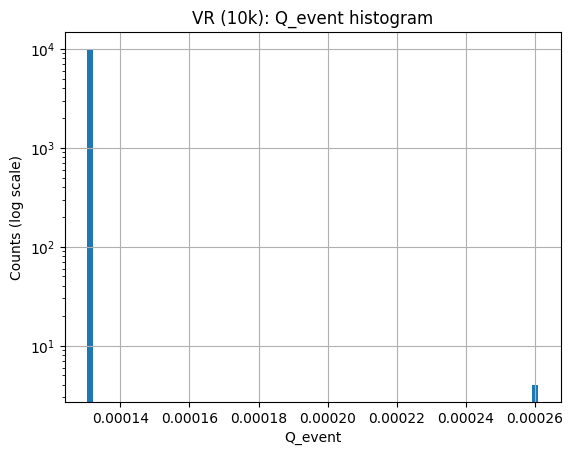

--- Stability report: Analog (100k) ---
N events          : 10000
Mean(Q_event)     : 1.000000e-04
Median(Q_event)   : 0.000000e+00
Max(Q_event)      : 1.000000e+00
Frac(Q=0)         : 99.99%
Frac(Q>0)         : 0.01%
Top-1 frac (sum)  : 100.00%
Top-10 frac (sum) : 100.00%
Max/Median        : inf


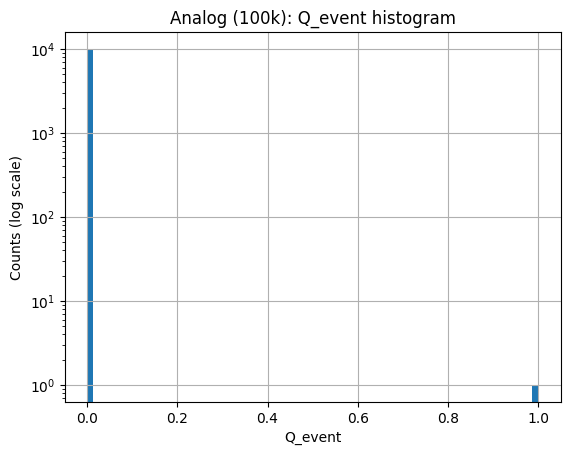

,label,N_events,max_over_median,frac_Q_eq_0_%,top1_%,top10_%
0,Analog (100k),10000,inf,99.99,100.000000,100.000000
1,VR (10k),10000,2.0,0.00,0.019992,0.139944


In [18]:
df_vr = load_eventQ(eventQ_vr_path)
df_an = load_eventQ(eventQ_an_path)

stats_vr = stability_diagnostics(df_vr, label="VR (10k)")
stats_an = stability_diagnostics(df_an, label="Analog (100k)")

print_stability_report(stats_vr)
plot_eventQ_hist(df_vr, title="VR (10k): Q_event histogram")

print_stability_report(stats_an)
plot_eventQ_hist(df_an, title="Analog (100k): Q_event histogram")

# Compact side-by-side summary table
summary = pd.DataFrame([stats_an, stats_vr])[[
    "label","N_events","frac_Q_eq_0","top1_frac_of_sum","top10_frac_of_sum","max_over_median"
]]
summary["frac_Q_eq_0_%"] = 100*summary["frac_Q_eq_0"]
summary["top1_%"] = 100*summary["top1_frac_of_sum"]
summary["top10_%"] = 100*summary["top10_frac_of_sum"]
summary = summary.drop(columns=["frac_Q_eq_0","top1_frac_of_sum","top10_frac_of_sum"])

display(summary)

## Check 3 — Stability: interpret the event-level diagnostics (analog vs VR)

You have produced, for **Analog (100k)** and **VR (10k)**:

- a histogram of `Q_event`,
- a stability report with summary diagnostics.

Use **both the histogram and the numbers** below to answer.

---

### A) What does the distribution look like?

1) **Zeros vs non-zeros**
- Compare `Frac(Q=0)` in analog and VR.
- What does this immediately tell you about *how* the total score is built in each case?

2) **Typical event contribution (VR)**
- Compare **median** and **mean** for VR.
- Are they close? What does that imply about event-to-event variability?

3) **Rare-event pattern (analog)**
- In the analog run, the median is 0 but the mean is non-zero.
- Explain in one sentence what this implies about the distribution of event contributions.

---

### B) Who carries the total score?

4) **Dominance test (top-1 / top-10)**
- Use `Top-1 frac (sum)` and `Top-10 frac (sum)`:
  - Which run is dominated by a handful of events?
  - Which run distributes the total sum across many events?

5) **Back-of-the-envelope: how many contributing events in analog?**
- Use: total sum $\approx \mathrm{Mean}(Q_{\mathrm{event}})\times N_{\mathrm{events}}$.
- If analog contributions are mostly 0 or 1, estimate how many events had $Q_{\mathrm{event}}=1$.
- Does that agree with the reported `Frac(Q>0)`?

---

### C) Stability verdict + red flags

6) **Stability verdict**
Using `max/median`, the top-1/top-10 fractions, and the histogram shape:

- Does the VR run show any sign of pathological spikes or heavy tails?
- Does the analog run show event-level instability (domination by rare events)?

7) **What would a *bad* VR setup look like in these diagnostics? (give two signatures)**  
Examples:
- extremely large `max/median`,
- top-1 or top-10 carrying a large fraction of the total sum,
- a histogram with a visible “spike far to the right” (rare extreme contributions).

---

### One-sentence takeaway (must cite at least two diagnostics)

Write one sentence comparing analog vs VR stability, explicitly citing:
- one histogram feature, and
- one numeric diagnostic (e.g. `Frac(Q=0)`, `Top-10 frac`, or `max/median`).

## Final conclusion — evaluating a rare-event Monte Carlo strategy

This hands-on was not about producing a single number.
It was about learning **how to evaluate a Monte Carlo strategy for a rare-event observable**.

You studied the *same physical problem* using two approaches:

- **Analog sampling**
- **Variance reduction (forced interactions with weights)**

and evaluated them using **three essential checks**.

---

### 1) Accuracy — correctness comes first

Use:
- Analog reference: **(100M)**  → $\mu_a$, $\sigma_a$
- VR run: **(10k)**            → $\mu_{vr}$, $\sigma_{vr}$

Compute:
$$
z=\frac{\mu_{vr}-\mu_a}{\sqrt{\sigma_{vr}^2+\sigma_a^2}}
$$

**Report:**
- $\mu_a =$ ________ , $\sigma_a =$ ________
- $\mu_{vr} =$ ________ , $\sigma_{vr} =$ ________
- $z =$ ________

**Accuracy conclusion (1 line):**  
Is $|z|\lesssim 2$? What does that imply about bias?  
_____________________________________________________________

---

### 2) Stability — event-level behaviour matters

Use the `eventQ_t0.tsv` diagnostics for:
- Analog baseline: **(100k)**
- VR run: **(10k)**

Write down at least **two** of the following for *each* run:
- `Frac(Q=0)` = ________ (analog) vs ________ (VR)
- `Top-10 frac (sum)` = ________ (analog) vs ________ (VR)
- `max/median` = ________ (analog) vs ________ (VR)

**Stability conclusion (1–2 lines):**  
Is the estimator dominated by a handful of events in either case?  
_____________________________________________________________

---

### 3) Efficiency — precision per unit time

Use the summaries from:
- Your best analog run (e.g. **100k**) → $R_a$, $T_a$, $\mathrm{FOM}_a$
- VR run (**10k**)                     → $R_{vr}$, $T_{vr}$, $\mathrm{FOM}_{vr}$

Compute and report:
- $R_a/R_{vr} =$ ________
- $T_{vr}/T_a =$ ________
- $\mathrm{FOM}_{vr}/\mathrm{FOM}_a =$ ________

**Efficiency conclusion (1–2 lines):**  
Is the improvement incremental, or orders of magnitude?  
_____________________________________________________________

---

## Final takeaway (mandatory synthesis)

Write **one short paragraph (3–4 lines)** answering:

> *For this observable, is variance reduction optional or essential?  
> Justify using **accuracy**, **stability**, and **efficiency** with at least one number in each.*

Avoid generic statements. Refer explicitly to what you observed.